# Reformating Denise Risch's minke whale annotations from Stellwagen Bank National Marine Sanctuary (2006)


## Purpose of this notebook
This notebook describes the steps involved in gathering, cleaning up and reorganizing the minke whale pulse train manual annotations that were performed by Denise Risch. Data are from MARU deployments conducted in 2006 in the Stellwagen Bank National Marine Sanctuary. Several recorders were deployed but here we will only use data from 2 consecutive deployments at site 6 from June to November 2006 (see map below). Annotations were perfoemd by ground-truthing automatic detection from the minke whale detector developped by Cornell. All confirmed detections were in .mat files from XBAT. All files from XBAT were then converted to Raven tables using the Matlab app provided by Mike Pitzrick. 

This fully annotated dataset will be used to assess the performance of the detector (i.e. quantify precision, recall, and number of false alarms per day)

The specific objectives of this notebook are:

- Convert the Raven annotation tables to have annotation times relative to the beginning of each audio file.
- Add metadata to all annotations (i.e., coordinates, depths, location, dates, etc)
- Make annotation labels consistent (i.e. 'MW' for minke)
- Create separte annotation tables for each recorder (channel)

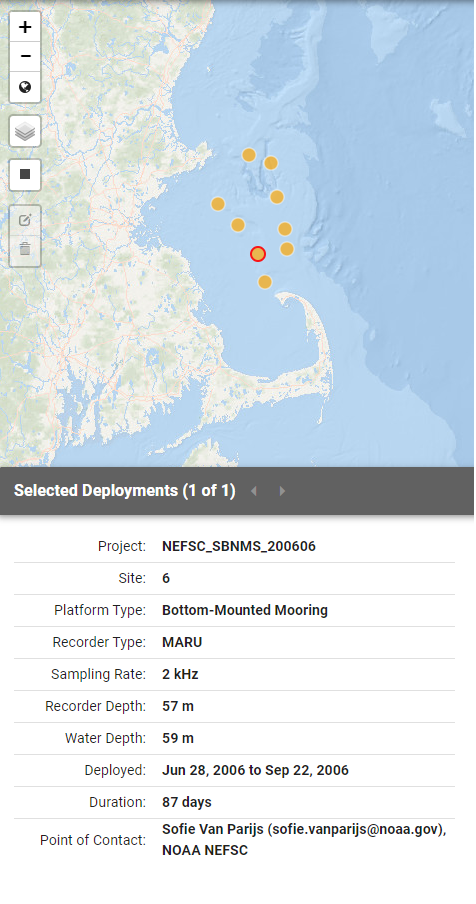

## Import libraries and define functions used throughout

In [1]:
import os
from ecosound.core.annotation import Annotation
from ecosound.core.metadata import DeploymentInfo
from ecosound.core.tools import list_files, filename_to_datetime
from ecosound.core.audiotools import Sound
import pandas as pd
from datetime import datetime
import re
import uuid
import matplotlib as mpl
import matplotlib.pyplot as plt
#import holoviews as hv
#import hvplot.pandas
#pd.options.plotting.backend = 'holoviews'
#hv.extension('bokeh')
%matplotlib

def get_datetime_from_filename(filename):
    time_format = "%Y%m%d_%H%M%S"
    file_offset_s_regex = "_[0-9]+s"
    file_offset_ms_regex = "_[0-9]+s"
    file_orig_regex = "_[0-9]{8}_[0-9]{6}"    
    # first part - date/time of origninal audio file
    p1 = re.compile(file_orig_regex)
    datestr_1 = p1.search(filename)
    date = datetime.strptime(datestr_1[0][1:],time_format)    
    ## second part - nb of seconds
    #p1 = re.compile(file_orig_regex)
    #datestr_1 = p1.search(df['Begin File'].iloc[0])
    #date = datetime.strptime(datestr_1[0][1:-1],time_format)    
    return date   

def load_raven_table(annotation_file,deployment_file):
    ## load Raven annotations
    df = pd.read_csv(annot_file, sep='\t')
    df = df[df['View']== 'Spectrogram 1'] # remove all "waveform" rows (redundant with the "Spectrogram" ones)
    df = df.reset_index(drop=True)  
    ## find out start date/time for each audio file
    files_date=df['Begin Path'].apply(get_datetime_from_filename)
    # Definition of start and stop time offsets of annoatations (relative to start of each audio file)
    duration = df['End Time (s)']-df['Begin Time (s)']
    start_offset = df['File Offset (s)']
    end_offset = start_offset + duration
    ## Populate annotation object
    annot = Annotation()
    annot.data['audio_file_start_date'] = files_date    
    annot.data['audio_file_name'] = df['Begin Path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
    annot.data['audio_file_dir'] = df['Begin Path'].apply(lambda x: os.path.dirname(x))
    annot.data['audio_file_extension'] = df['Begin Path'].apply(lambda x: os.path.splitext(x)[1])
    annot.data['time_min_offset'] = start_offset
    annot.data['time_max_offset'] = end_offset
    annot.data['time_min_date'] = pd.to_datetime(annot.data['audio_file_start_date'] + pd.to_timedelta(annot.data['time_min_offset'], unit='s'))
    annot.data['time_max_date'] = pd.to_datetime(annot.data['audio_file_start_date'] + pd.to_timedelta(annot.data['time_max_offset'], unit='s'))
    annot.data['frequency_min'] = df['Low Freq (Hz)']
    annot.data['frequency_max'] = df['High Freq (Hz)']    
    annot.data['label_class'] = 'MW'#df['Tags']  
    annot.data['label_subclass'] = df['Tags']  
    annot.data['from_detector'] = False
    annot.data['software_name'] = 'raven'
    annot.data['uuid'] = annot.data.apply(lambda _: str(uuid.uuid4()), axis=1)
    annot.data['duration'] = annot.data['time_max_offset'] - annot.data['time_min_offset']    
    annot.insert_metadata(os.path.join(deployment_file)) # insert metadata
    annot.data['audio_channel'] = df['Channel']-1
    annot.check_integrity(verbose=False, ignore_frequency_duplicates=True) # check integrity
    #print(len(annot), 'annotations imported.')
    return annot

Using matplotlib backend: <object object at 0x000001C599ECCB60>


## Deployment 1: SBNMS_20060629 - channel 6

In [2]:
annotation_dir = r'D:\NOAA\2022_Minke_whale_detector\manual_annotations\continuous_datasets\USA-NEFSC-SBNMS-200606-CH6\old_format\SBNMS_20060629_ALLch_2kHz'
deployment_file = r'D:\NOAA\2022_Minke_whale_detector\manual_annotations\continuous_datasets\USA-NEFSC-SBNMS-200606-CH6\deployment_info.csv'
audio_dir = r'Z:\ACOUSTIC_DATA\BOTTOM_MOUNTED\NEFSC_SBNMS\NEFSC_SBNMS_200606\NEFSC_SBNMS_200606_EST'
out_dir = r'D:\NOAA\2022_Minke_whale_detector\manual_annotations\continuous_datasets\USA-NEFSC-SBNMS-200606-CH6'

In [3]:
# Import all Raven tables
annot_files = list_files(annotation_dir,'.txt',recursive=False,case_sensitive=True)
annot = Annotation()
annot_files = list_files(annotation_dir,'.txt',recursive=False,case_sensitive=True)
for annot_file in annot_files:
    annot_tmp = load_raven_table(annot_file, deployment_file)
    annot = annot + annot_tmp
annot.check_integrity()
annot.summary(rows='audio_channel', columns='label_class')

label_class,MW,Total
audio_channel,,
0,655,655
1,2964,2964
2,3381,3381
3,9447,9447
4,6044,6044
5,20421,20421
6,14541,14541
7,4532,4532
8,17923,17923


### Only keep channel 6

In [4]:
annot_ch6 = annot.filter('audio_channel==6')
annot_ch6.summary(rows='audio_channel', columns='label_class')

label_class,MW,Total
audio_channel,,
6,14541,14541
Total,14541,14541


In [5]:
annot_ch6.calc_time_aggregate_1D(integration_time='1D')

,value
datetime,
2006-06-28,62
2006-06-29,36
2006-06-30,87
2006-07-01,171
2006-07-02,58
2006-07-03,60
2006-07-04,88
2006-07-05,144
2006-07-06,82


### Verify and update path of the audio folder

In [6]:
annot_ch6.update_audio_dir(new_data_dir=audio_dir)

In [7]:
# save to NetCDF and Raven format
annot_ch6.to_netcdf(os.path.join(out_dir, 'Annotations_dataset_' + annot.data['deployment_ID'][0] +' annotations.nc'))
annot_ch6.to_raven(out_dir, outfile='Annotations_dataset_' + annot.data['deployment_ID'][0] +'.Table.1.selections.txt', single_file=True)

C:\Users\xavier.mouy\AppData\Local\anaconda3\envs\ecosound-dev\lib\site-packages\xarray\coding\times.py:618: RuntimeWarning: invalid value encountered in cast
  int_num = np.asarray(num, dtype=np.int64)


## Deployment 2: SBNMS_20060921 - channel 8

In [8]:
annotation_dir = r'D:\NOAA\2022_Minke_whale_detector\manual_annotations\continuous_datasets\USA-NEFSC-SBNMS-200609-CH8\old_format\SBNMS_20060921_ALLch_2kHz'
deployment_file =r'D:\NOAA\2022_Minke_whale_detector\manual_annotations\continuous_datasets\USA-NEFSC-SBNMS-200609-CH8\deployment_info.csv'
out_dir = r'D:\NOAA\2022_Minke_whale_detector\manual_annotations\continuous_datasets\USA-NEFSC-SBNMS-200609-CH8'
audio_dir =r'Z:\ACOUSTIC_DATA\BOTTOM_MOUNTED\NEFSC_SBNMS\NEFSC_SBNMS_200609\NEFSC_SBNMS_200609_EST'

In [9]:
annot_files = list_files(annotation_dir,'.txt',recursive=False,case_sensitive=True)
annot = Annotation()
annot_files = list_files(annotation_dir,'.txt',recursive=False,case_sensitive=True)
for annot_file in annot_files:
    annot_tmp = load_raven_table(annot_file, deployment_file)
    annot = annot + annot_tmp
annot.check_integrity()
annot.summary(rows='audio_channel', columns='label_class')

label_class,MW,Total
audio_channel,,
0,5935,5935
1,2556,2556
2,7806,7806
3,3937,3937
4,498,498
5,2546,2546
6,4049,4049
7,5163,5163
8,3205,3205


### Only keep channel 8

In [10]:
annot_ch8 = annot.filter('audio_channel==8')
annot_ch8.summary(rows='audio_channel', columns='label_class')

label_class,MW,Total
audio_channel,,
8,3205,3205
Total,3205,3205


In [11]:
annot_ch8.calc_time_aggregate_1D(integration_time='1D')

,value
datetime,
2006-10-04,6
2006-10-05,27
2006-10-06,2
2006-10-07,19
2006-10-08,63
2006-10-09,27
2006-10-10,5
2006-10-11,29
2006-10-12,29


### Verify and update path of the audio folder

In [12]:
annot_ch8.update_audio_dir(new_data_dir=audio_dir)

The dataset can now be saved as a Raven annotation file and netcdf4 file:

In [13]:
# save to NetCDF and Raven format
annot_ch8.to_netcdf(os.path.join(out_dir, 'Annotations_dataset_' + annot.data['deployment_ID'][0] +' annotations.nc'))
annot_ch8.to_raven(out_dir, outfile='Annotations_dataset_' + annot.data['deployment_ID'][0] +'.Table.1.selections.txt', single_file=True)

C:\Users\xavier.mouy\AppData\Local\anaconda3\envs\ecosound-dev\lib\site-packages\xarray\coding\times.py:618: RuntimeWarning: invalid value encountered in cast
  int_num = np.asarray(num, dtype=np.int64)
